# Transfer Learning - PyTorch

### Setting up the Frameworks


In [1]:
# Install PyTorch
import sys
! {sys.executable} -m pip install --upgrade torch
! {sys.executable} -m pip install --upgrade torchvision

# Import PyTorch Libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print('Ready to train a model using PyTorch', torch.__version__)

    100% |████████████████████████████████| 560.1MB 143kB/s eta 0:00:01 1% |▌                               | 8.1MB 23.7MB/s eta 0:00:24    3% |█▎                              | 22.3MB 22.6MB/s eta 0:00:24    10% |███▍                            | 60.3MB 73.5MB/s eta 0:00:07    15% |█████                           | 85.7MB 33.8MB/s eta 0:00:15    20% |██████▌                         | 113.0MB 70.1MB/s eta 0:00:07    31% |██████████▏                     | 177.7MB 8.8MB/s eta 0:00:44    42% |█████████████▌                  | 235.7MB 21.3MB/s eta 0:00:16    48% |███████████████▊                | 274.2MB 22.2MB/s eta 0:00:13    56% |██████████████████              | 316.1MB 42.2MB/s eta 0:00:06�████████▏            | 335.9MB 32.3MB/s eta 0:00:07    65% |█████████████████████           | 368.8MB 60.8MB/s eta 0:00:04    69% |██████████████████████          | 386.4MB 71.2MB/s eta 0:00:03
  Found existing installation: torch 1.0.0
    Uninstalling torch-1.0.0:
      Successfully uninstalled to

### Loading and Preparing the Data

In [2]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    
    # Resize to 256 x 256, center-crop to 224x224 (to match the resnet image size), and convert to Tensor
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    # Split into training (70%) and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 32-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=4,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 32-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=4,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Now load the images from the shapes folder
import os  
data_path = 'resized_images/'

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(classes)

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)

['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents']


### Downloading a trained model to user as a base

In [3]:
model_resnet = torchvision.models.resnet18(pretrained=True)
for param in model_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(classes))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/graeme/.torch/models/resnet18-5c106cde.pth
46827520it [00:02, 18923063.63it/s]


### Training the Model

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        # Reset the optimizer
        optimizer.zero_grad()
        # Push the data forward through the model layers
        output = model(data)
        # Get the loss
        loss = loss_criteria(output, target)
        # Keep a running total
        train_loss += loss.item()
        # Backpropagate
        loss.backward()
        optimizer.step()
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    # return average loss for the epoch
    return train_loss / len(train_loader.dataset)
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # Get the predicted classes for this batch
            output = model(data)
            # calculate the loss and successful predictions for this batch
            test_loss += loss_criteria(output, target).item()
            pred = output.max(1, keepdim=True)[1] 
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate the average loss and total accuracy for this epoch
    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return test_loss
    
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model_resnet = model_resnet.to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 5 epochs
epochs = 5
for epoch in range(1, epochs + 1):
        train_loss = train(model_resnet, device, train_loader, optimizer, epoch)
        test_loss = test(model_resnet, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)


Training on cuda
Epoch: 1
Training set [0/1485 (0%)] Loss: 2.353874
Training set [40/1485 (3%)] Loss: 3.336500
Training set [80/1485 (5%)] Loss: 1.506933
Training set [120/1485 (8%)] Loss: 2.029165
Training set [160/1485 (11%)] Loss: 2.168442
Training set [200/1485 (13%)] Loss: 2.082566
Training set [240/1485 (16%)] Loss: 1.084810
Training set [280/1485 (19%)] Loss: 1.061181
Training set [320/1485 (22%)] Loss: 1.404296
Training set [360/1485 (24%)] Loss: 1.369275
Training set [400/1485 (27%)] Loss: 1.217853
Training set [440/1485 (30%)] Loss: 1.359615
Training set [480/1485 (32%)] Loss: 1.780647
Training set [520/1485 (35%)] Loss: 0.501573
Training set [560/1485 (38%)] Loss: 1.042233
Training set [600/1485 (40%)] Loss: 1.080094
Training set [640/1485 (43%)] Loss: 0.717371
Training set [680/1485 (46%)] Loss: 1.732307
Training set [720/1485 (48%)] Loss: 1.303115
Training set [760/1485 (51%)] Loss: 0.530221
Training set [800/1485 (54%)] Loss: 1.191460
Training set [840/1485 (56%)] Loss: 1

Training set [960/1485 (65%)] Loss: 0.077786
Training set [1000/1485 (67%)] Loss: 0.003851
Training set [1040/1485 (70%)] Loss: 0.452314
Training set [1080/1485 (73%)] Loss: 0.138960
Training set [1120/1485 (75%)] Loss: 0.112871
Training set [1160/1485 (78%)] Loss: 0.014183
Training set [1200/1485 (81%)] Loss: 0.108612
Training set [1240/1485 (83%)] Loss: 0.061173
Training set [1280/1485 (86%)] Loss: 0.477670
Training set [1320/1485 (89%)] Loss: 0.095760
Training set [1360/1485 (91%)] Loss: 0.323942
Training set [1400/1485 (94%)] Loss: 0.046310
Training set [1440/1485 (97%)] Loss: 0.070035
Training set [1480/1485 (99%)] Loss: 0.113134
Test set: Average loss: 0.0205, Accuracy: 624/637 (98%)



### View the Loss History

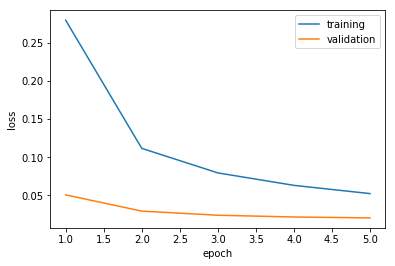

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Using the Trained Model

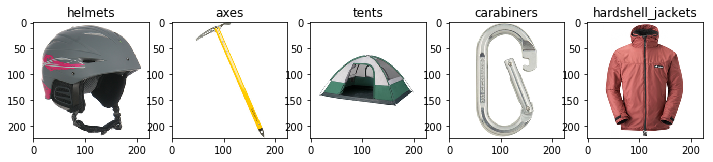

In [6]:
# Helper function to make image square
def reshape_image(img, size): 
    from PIL import Image, ImageOps 
    
    # Convert RGBA images to RGB
    if np.array(img).shape[2] == 4:
        img = img.convert('RGB')
        
    # resize the image
    img.thumbnail(size, Image.ANTIALIAS)
    newimg = Image.new("RGB", size, (255, 255, 255))
    newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
  
    # return the resized image
    return np.array(newimg)

# Function to predict the class of an image
def predict_image(classifier, image_array):
    from PIL import Image
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # These are the classes our model can predict
    class_names = ['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents']
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the imagees
    image_tensor = torch.stack([transformation(Image.fromarray(image)).float() for image in image_array])

    # Turn the input into a Variable
    input_features = Variable(image_tensor).to(device)

    # Predict the class of each input image
    predictions = classifier(input_features)
    
    predicted_classes = []
    # Convert the predictions to a numpy array 
    for prediction in predictions.cpu().data.numpy():
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(class_names[class_idx])
    return np.array(predicted_classes)

# Predict class for new data
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

image_urls = []
image_urls.append('http://images.the-house.com/giro-g10mx-mtgy-07.jpg')
image_urls.append('https://i.stack.imgur.com/HeliW.jpg')
image_urls.append('https://productimages.camping-gear-outlet.com/e5/62379.jpg')
image_urls.append('http://s7d1.scene7.com/is/image/MoosejawMB/MIKAJMKFMKCAPNABx1024698_zm?$product1000$')
image_urls.append('http://www.buffalosystems.co.uk/wp-content/uploads/2012/06/zoom_apline_jacket_dark_russet-2365x3286.jpg')

size = (224,224)

img_array = []

for url_idx in range(len(image_urls)):
    # Get the image
    response = requests.get(image_urls[url_idx])
    img = Image.open(BytesIO(response.content))
    img = reshape_image(img, size)
    img_array.append(img)
    
predicted_classes = predict_image(model_resnet, np.array(img_array))

fig = plt.figure(figsize=(12, 8))
idx = 0
for predicted_class in predicted_classes:
    a=fig.add_subplot(1,len(image_urls),idx+1)
    img = img_array[idx]
    imgplot = plt.imshow(img)
    a.set_title(predicted_class)
    idx += 1

